---
# NLP
---


### Importing necessary library

In [35]:
import pandas as pd
import numpy as np

import requests
import pandas as pd
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from summarizer import Summarizer,TransformerSummarizer
#from summarizer import Summarizer,TransformerSummarizer
#from transformers import pipeline

---

<center>
    
## Preparing data

</center>

---

### Read data file

In [4]:
df = pd.read_csv('../data/games_comments_clean.csv')
df

,username,rating,comment,max_players,minplaytime,maxplaytime,age,ratings_avg,count_wanting,count_wishing,lang
0,causticforever,NaN,Played prototype- will be an enjoyable way to ...,5,40,100,12,3.5,44,460,en
1,Corwin007,NaN,UPCOMING\n\nArk Nova lite?,5,40,100,12,3.5,44,460,en
2,IronTarkles,NaN,New game from ark nova designer,5,40,100,12,3.5,44,460,en
3,MarkyX,NaN,I'm very interested in this one. I like the co...,5,40,100,12,3.5,44,460,en
4,mikamikomi,1.0,3 artist yet still use stock photos? oh yeah,5,40,100,12,3.5,44,460,en
...,...,...,...,...,...,...,...,...,...,...,...
4158,Aenelruun,8.5,LM,4,40,80,10,8.00569,1422,21393,en
4159,Aeremia,6.0,Cute little game with amazing artwork and nice...,4,40,80,10,8.00569,1422,21393,en
4160,Aevey,9.0,"Only had a few playthroughs so far, but very e...",4,40,80,10,8.00569,1422,21393,en
4161,afafard,7.0,Fairly simple and quick engine builder.\nHas a...,4,40,80,10,8.00569,1422,21393,en


---

<center>
    
## NLP - Sentiment

</center>

---

### Create an instance of the model

In [5]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

2025-03-26 15:55:09.108591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743018909.303955  436159 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743018909.346138  436159 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743018909.876874  436159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743018909.877277  436159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743018909.877289  436159 computation_placer.cc:177] computation placer alr

### Encode the reviews and use model to predict sentiment for each review

In [14]:
# Creating function to encode each review and return the sentiment score from 1 to 5 
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    rating_1_5 = torch.argmax(result.logits).item() + 1
    rating_1_10 = np.round(2 * rating_1_5, decimals=1)
    return rating_1_10

In [15]:
# Add Sentiment column that contains the sentiment prediction of the model based on the review
df['Sentiment'] = df['comment'].apply(lambda x: sentiment_score(x[:512]))
df

,username,rating,comment,max_players,minplaytime,maxplaytime,age,ratings_avg,count_wanting,count_wishing,lang,Sentiment
0,causticforever,NaN,Played prototype- will be an enjoyable way to ...,5,40,100,12,3.5,44,460,en,8
1,Corwin007,NaN,UPCOMING\n\nArk Nova lite?,5,40,100,12,3.5,44,460,en,6
2,IronTarkles,NaN,New game from ark nova designer,5,40,100,12,3.5,44,460,en,10
3,MarkyX,NaN,I'm very interested in this one. I like the co...,5,40,100,12,3.5,44,460,en,8
4,mikamikomi,1.0,3 artist yet still use stock photos? oh yeah,5,40,100,12,3.5,44,460,en,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4158,Aenelruun,8.5,LM,4,40,80,10,8.00569,1422,21393,en,6
4159,Aeremia,6.0,Cute little game with amazing artwork and nice...,4,40,80,10,8.00569,1422,21393,en,6
4160,Aevey,9.0,"Only had a few playthroughs so far, but very e...",4,40,80,10,8.00569,1422,21393,en,8
4161,afafard,7.0,Fairly simple and quick engine builder.\nHas a...,4,40,80,10,8.00569,1422,21393,en,8


---

<center>
    
## NLP - Summarization

</center>

---

**BERT**

In [36]:
bert_model = Summarizer()

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [37]:
def comment2summaryBERT(comment):
    summary = ''.join(bert_model(comment, num_sentences=1))
    return summary

In [ ]:
# Add Summary column that contains the summary of the comment based on NLP summarization
df['Summary_BERT'] = df['comment'].apply(lambda x: comment2summaryBERT(x))
df

**BART**

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

In [ ]:
def comment2summaryBART(comment):
    summary = summarizer(comment, max_length=50, min_length=1, do_sample=False)
    return summary

In [ ]:
df['Summary_BERT'] = df['comment'].apply(lambda x: comment2summaryBART(x)))
df

---

<center>
    
## Saving data to file

</center>

---

In [16]:
df.to_csv('../data/games_comments_sentiment_summarized.csv', index=False)

---

<center>
    
## Evaluate Sentiment rating vs true rating

</center>

---

In [ ]:
tmp = df.dropna(subset=['rating'])

In [19]:
tmp['rating'].unique()

array(['1.0', '9.0', 'rating', '8.0', '8.5', '7.0', '4.0', '7.5', '5.5',
       '7.3', '10.0', '5.0', '6.0', '6.5', '8.4', '8.2', '9.5', '9.2',
       '9.3', '8.8', '7.8', '3.0', '6.8', '7.9', '7.1', '6.4', '8.36',
       '7.7', '8.6', '9.4', '9.6', '6.05', '3.7', '2.0', '6.6', '7.75',
       '7.2', '3.5', '8.7', '8.75', '8.3', '6.3', '4.5', '9.75', '7.6',
       '2.5', '9.21', '7.25', '4.9', '9.9', '8.79', '8.9', '9.1', '8.64',
       '5.9', '6.57', '7.4', '7.84', '9.25', '8.25', '4.8', '9.45',
       '8.33'], dtype=object)

In [22]:
tmp = tmp[tmp['rating'] != 'rating']

In [23]:
tmp['rating'] = tmp['rating'].astype(float)

/tmp/ipykernel_436159/4230414817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['rating'] = tmp['rating'].astype(float)


In [25]:
tmp['rating'].unique()

array([ 1.  ,  9.  ,  8.  ,  8.5 ,  7.  ,  4.  ,  7.5 ,  5.5 ,  7.3 ,
       10.  ,  5.  ,  6.  ,  6.5 ,  8.4 ,  8.2 ,  9.5 ,  9.2 ,  9.3 ,
        8.8 ,  7.8 ,  3.  ,  6.8 ,  7.9 ,  7.1 ,  6.4 ,  8.36,  7.7 ,
        8.6 ,  9.4 ,  9.6 ,  6.05,  3.7 ,  2.  ,  6.6 ,  7.75,  7.2 ,
        3.5 ,  8.7 ,  8.75,  8.3 ,  6.3 ,  4.5 ,  9.75,  7.6 ,  2.5 ,
        9.21,  7.25,  4.9 ,  9.9 ,  8.79,  8.9 ,  9.1 ,  8.64,  5.9 ,
        6.57,  7.4 ,  7.84,  9.25,  8.25,  4.8 ,  9.45,  8.33])

In [27]:
tmp['Sentiment'].unique()

array([ 6,  8, 10,  2,  4])

In [24]:
print("Classification Report:\n", classification_report(tmp['rating'], tmp['Sentiment']))

ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

### Comparing distribution count of Sentiment values vs Ratings 

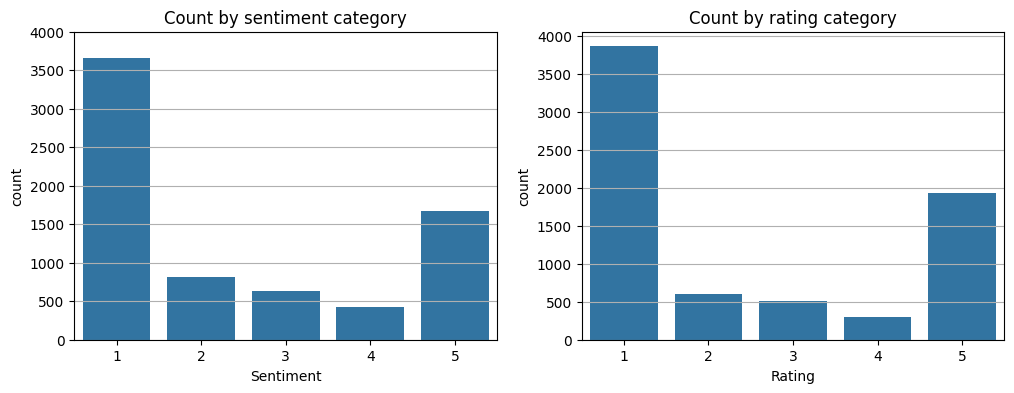

In [30]:
# Create the figure and adjust its size
fig , (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

sns.countplot(ax=ax2, data=tmp,x='Rating', order=list(np.arange(1,10.5,0.5)))
sns.countplot(ax=ax1, data=tmp,x='Sentiment', order=list(np.arange(1,10.5,0.5)))

# Set the axis labels 
ax1.set_xlabel('Rating')
ax1.set_xlabel('Sentiment')

# Set Title
ax1.set_title('Count by sentiment category')
ax2.set_title('Count by rating category')

# Set y-axis limit
ax1.set_ylim(0,4000)

# Show grid on y axis
ax1.grid(axis='y')
ax2.grid(axis='y')

plt.show()

---

<center>
    
## Results

</center>

---